In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, LSTM, GlobalAveragePooling1D, Multiply, Reshape
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [3]:
def load_group(filenames, prefix=''):
    loaded = [load_file(prefix + name) for name in filenames]
    loaded = np.dstack(loaded)
    return loaded

In [4]:
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [5]:
def load_dataset(prefix=''):
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/')
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/')
    trainy = trainy - 1
    testy = testy - 1
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [6]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [7]:
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy, test_size=0.2, random_state=100
)

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [8]:
def se_block(input_tensor, ratio=16):
    channels = int(input_tensor.shape[-1])
    se = GlobalAveragePooling1D()(input_tensor)
    se = Dense(channels // ratio, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    se = Reshape((1, channels))(se)
    x = Multiply()([input_tensor, se])
    return x

In [9]:
inputs = Input(shape=(n_timesteps, n_features))
lstm_out = LSTM(128, return_sequences=True)(inputs)
lstm_se = se_block(lstm_out)
lstm_out2 = LSTM(64)(lstm_se)
dense = Dense(512, activation='relu')(lstm_out2)
outputs = Dense(n_outputs, activation='softmax')(dense)

lstm_se_model = Model(inputs, outputs)
lstm_se_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_se_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128, 128)  │     70,656 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ lstm[0][0]        │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │      1,032 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      1,152 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 128)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 128, 128)  │          0 │ lstm[0][0],       │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     49,408 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │     33,280 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 6)         │      3,078 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 158,606 (619.55 KB)

 Trainable params: 158,606 (619.55 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model_history = lstm_se_model.fit(
    X_train,
    y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 225ms/step - accuracy: 0.5034 - loss: 1.2111 - val_accuracy: 0.6876 - val_loss: 0.7427
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 34s 206ms/step - accuracy: 0.6805 - loss: 0.7236 - val_accuracy: 0.7725 - val_loss: 0.5184
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 205ms/step - accuracy: 0.8282 - loss: 0.4257 - val_accuracy: 0.8879 - val_loss: 0.3089
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 36s 215ms/step - accuracy: 0.9000 - loss: 0.2933 - val_accuracy: 0.9508 - val_loss: 0.1536
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 34s 204ms/step - accuracy: 0.9460 - loss: 0.1481 - val_accuracy: 0.9423 - val_loss: 0.1371
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 35s 213ms/step - accuracy: 0.9390 - loss: 0.1629 - val_accuracy: 0.9321 - val_loss: 0.1534
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 213ms/step - accuracy: 0.9455 - loss: 0.1420 - val_accuracy: 0.9610 - val_loss: 0.1103
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 34s 204ms/step - accuracy: 0.9186 - loss: 0

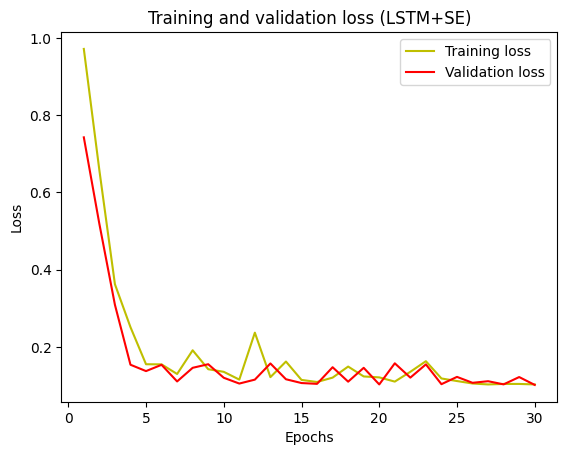

In [11]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (LSTM+SE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

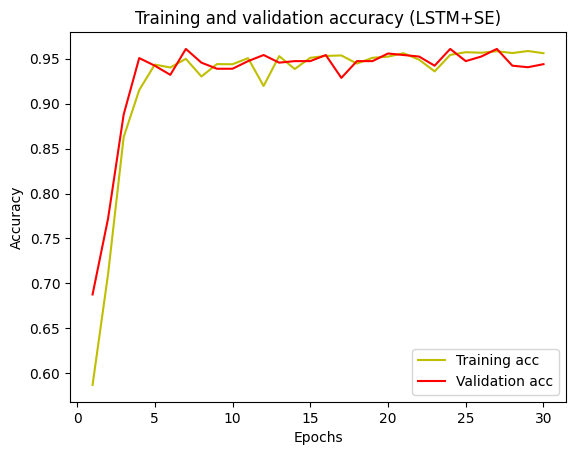

In [12]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy (LSTM+SE)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step
[[468   4  24   0   0   0]
 [  0 456  14   0   1   0]
 [  0   3 417   0   0   0]
 [  0  25   0 369  96   1]
 [  1  38   0  60 433   0]
 [  0  15   0   0   0 522]]
0.9043094672548354
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       496
           1       0.84      0.97      0.90       471
           2       0.92      0.99      0.95       420
           3       0.86      0.75      0.80       491
           4       0.82      0.81      0.82       532
           5       1.00      0.97      0.98       537

    accuracy                           0.90      2947
   macro avg       0.91      0.91      0.90      2947
weighted avg       0.91      0.90      0.90      2947



<Axes: >

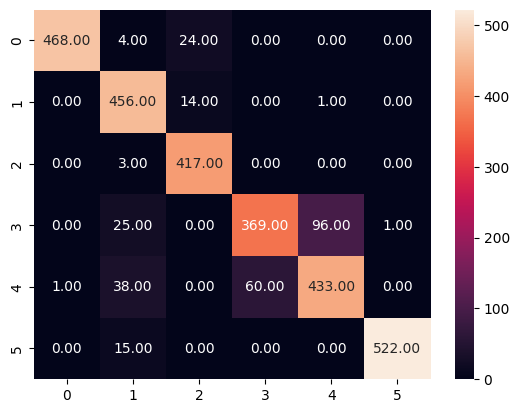

In [13]:
pred = lstm_se_model.predict(testX)
pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(testy, pred)
print(cm)
print(accuracy_score(testy, pred))
print(classification_report(testy, pred))
sns.heatmap(cm, annot=True, fmt='.2f')